In [2]:
# Configuración de PySpark para mac m1
import os
import sys

# Configurar Java y Spark  local
os.environ['JAVA_HOME'] = "/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home"
os.environ['SPARK_HOME'] = '/opt/homebrew/opt/apache-spark/libexec'
os.environ['PYSPARK_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import json

spark = SparkSession.builder \
    .appName("CustomerDataAnalysis") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

print("Sesión de Spark inicializada")

Sesión de Spark inicializada


In [ ]:
file_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..", "data", "customer.csv")
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(file_path)

df.createOrReplaceTempView("customers")

print(f"Número total de registros: {df.count()}")
print("\nEsquema del DataFrame:")
df.printSchema()

print("\nPrimeros 5 registros:")
df.show(5, truncate=False)

25/04/11 17:50:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Número total de registros: 190456

Esquema del DataFrame:
root
 |-- user_id: string (nullable = true)
 |-- email: string (nullable = true)
 |-- status: string (nullable = true)
 |-- name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- is_investor: string (nullable = true)
 |-- is_trader: string (nullable = true)
 |-- account_number: string (nullable = true)
 |-- investor_date: string (nullable = true)
 |-- language: string (nullable = true)
 |-- city: string (nullable = true)
 |-- investment_objective: string (nullable = true)
 |-- investment_experience: string (nullable = true)
 |-- total_networth: string (nullable = true)
 |-- annual_income: string (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- first_deposit_type: string (nullable = true)
 |-- fiat_first_deposit_transfer_id: string (nullable = true)
 |-- fiat_fi

Distribución de usuarios por país (incluyendo nulos):
+-------+----------+
|country|user_count|
+-------+----------+
|     CO|     91395|
|     PE|     31865|
|     EC|     13563|
|     MX|     11448|
|     AR|     10158|
|     CL|      8459|
|     GT|      4168|
|     VE|      4067|
|     BO|      3705|
|     DO|      3069|
+-------+----------+
only showing top 10 rows



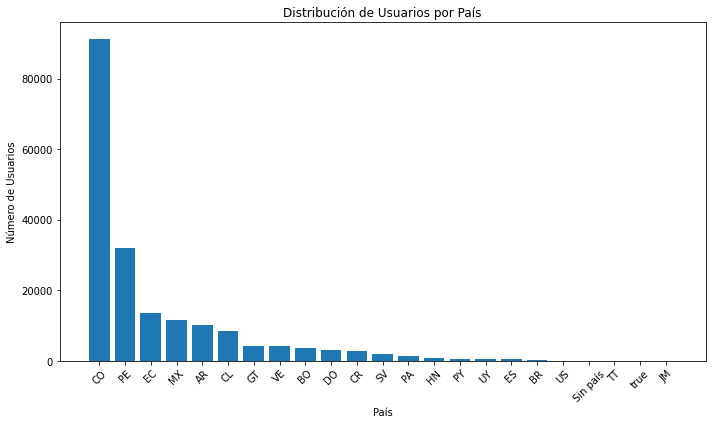

In [7]:
country_distribution = spark.sql("""
    SELECT 
        COALESCE(country, 'Sin país') as country, 
        COUNT(*) as user_count
    FROM customers
    GROUP BY COALESCE(country, 'Sin país')
    ORDER BY user_count DESC
""")

print("Distribución de usuarios por país (incluyendo nulos):")
country_distribution.show(10)

country_pd = country_distribution.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(country_pd['country'], country_pd['user_count'])
plt.title('Distribución de Usuarios por País')
plt.xlabel('País')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribución por estado de cuenta:
+--------------------+------+
|              status| count|
+--------------------+------+
|   ONBOARD_COMPLETED|190251|
|              CLOSED|    89|
|WITHOUT_KYC_WITH_...|    59|
|COMPLETED_WITHOUT...|    21|
|      KYC_PROCESSING|    19|
|          INCOMPLETE|     6|
|          PROCCESING|     4|
|KYC_WITHOUT_COMPL...|     3|
|2024-05-21 14:22:...|     1|
|2025-03-16 02:17:...|     1|
|2025-01-06 02:21:...|     1|
|       INVESTIGATION|     1|
+--------------------+------+



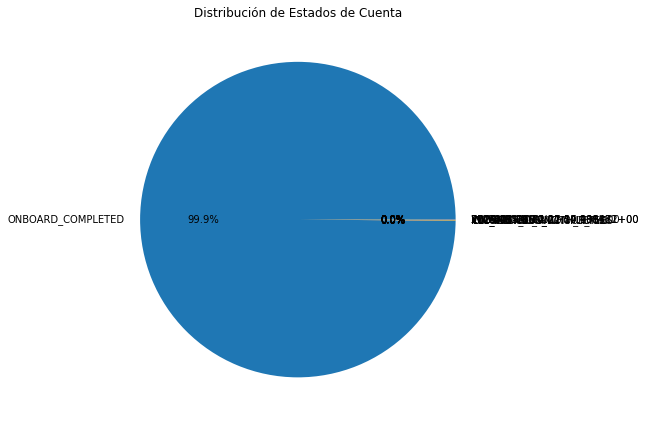

In [6]:
status_distribution = spark.sql("""
    SELECT 
        status, 
        COUNT(*) as count
    FROM customers
    GROUP BY status
    ORDER BY count DESC
""")

print("Distribución por estado de cuenta:")
status_distribution.show()

status_pd = status_distribution.toPandas()
plt.figure(figsize=(10, 6))
plt.pie(status_pd['count'], labels=status_pd['status'], autopct='%1.1f%%')
plt.title('Distribución de Estados de Cuenta')
plt.tight_layout()
plt.show()

Depósitos por mes:
+-------+-------------+--------------------+------------------+
|  month|deposit_count|total_deposit_amount|avg_deposit_amount|
+-------+-------------+--------------------+------------------+
|2022-03|          404|  122168.84000000001| 302.3981188118812|
|2022-04|         1578|           231966.12|147.00007604562737|
|2022-05|         1648|           199951.58| 121.3298422330097|
|2022-06|         1175|           158956.78| 135.2823659574468|
|2022-07|         1755|  178118.33999999997| 101.4919316239316|
|2022-08|         2049|  206346.24000000002| 100.7058272327965|
|2022-09|         2139|            194546.7| 90.95217391304348|
|2022-10|         1703|  242179.41999999998|142.20752789195535|
|2022-11|         2150|           302245.97|140.57952093023255|
|2022-12|         1608|           242406.38|150.75023631840796|
|2023-01|         2935|  455198.07999999996| 155.0930425894378|
|2023-02|         2075|           310397.12| 149.5889734939759|
|2023-03|         263

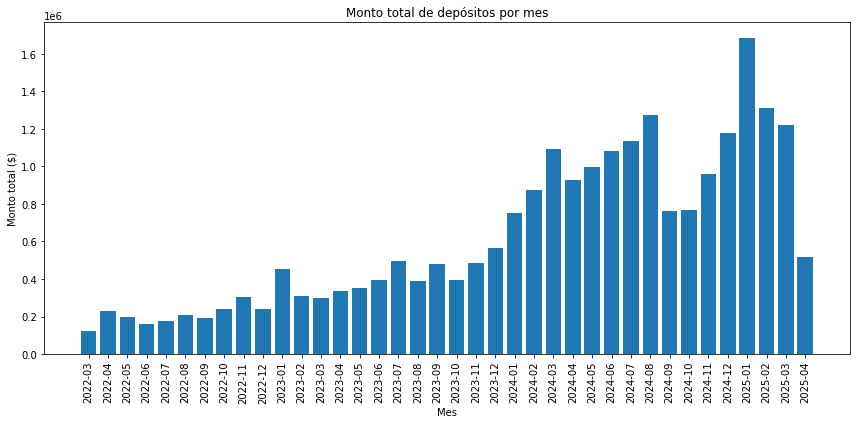

In [8]:
deposit_by_time = spark.sql("""
    SELECT 
        date_format(fiat_first_deposit_created_at, 'yyyy-MM') as month,
        COUNT(*) as deposit_count,
        SUM(fiat_first_deposit_amount) as total_deposit_amount,
        AVG(fiat_first_deposit_amount) as avg_deposit_amount
    FROM customers
    WHERE fiat_first_deposit_created_at IS NOT NULL
    GROUP BY date_format(fiat_first_deposit_created_at, 'yyyy-MM')
    ORDER BY month
""")

print("Depósitos por mes:")
deposit_by_time.show(20)

deposit_pd = deposit_by_time.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(deposit_pd['month'], deposit_pd['total_deposit_amount'])
plt.title('Monto total de depósitos por mes')
plt.xlabel('Mes')
plt.ylabel('Monto total ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Análisis de experiencia vs objetivo de inversión:
+--------------------+---------------------+----------+
|investment_objective|investment_experience|user_count|
+--------------------+---------------------+----------+
|              INCOME|                 NONE|     44823|
|              INCOME|             A_LITTLE|     34761|
|              GROWTH|                 NONE|     31628|
|              GROWTH|             A_LITTLE|     29079|
|              GROWTH|                 GOOD|     13337|
|              INCOME|                 GOOD|     10633|
|CAPITAL_PRESERVATION|             A_LITTLE|      9224|
|CAPITAL_PRESERVATION|                 NONE|      8633|
|CAPITAL_PRESERVATION|                 GOOD|      3644|
|         SPECULATION|                 NONE|       925|
|              GROWTH|               EXPERT|       833|
|         SPECULATION|                 GOOD|       758|
|         SPECULATION|             A_LITTLE|       742|
|              INCOME|               EXPERT|       464

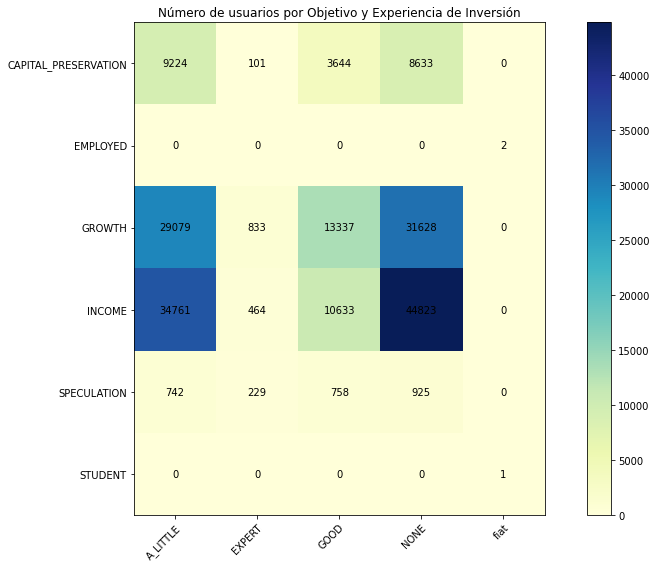

In [9]:
investment_analysis = spark.sql("""
    SELECT 
        investment_objective,
        investment_experience,
        COUNT(*) as user_count
    FROM customers
    WHERE investment_objective IS NOT NULL
      AND investment_experience IS NOT NULL
    GROUP BY investment_objective, investment_experience
    ORDER BY user_count DESC
""")

print("Análisis de experiencia vs objetivo de inversión:")
investment_analysis.show()

inv_pd = investment_analysis.toPandas()

pivot_table = inv_pd.pivot(index='investment_objective', 
                          columns='investment_experience', 
                          values='user_count').fillna(0)

plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
im = ax.imshow(pivot_table.values, cmap='YlGnBu')

ax.set_xticks(range(len(pivot_table.columns)))
ax.set_yticks(range(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns)
ax.set_yticklabels(pivot_table.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = ax.text(j, i, int(pivot_table.iloc[i, j]),
                       ha="center", va="center", color="black")

plt.colorbar(im)
plt.title('Número de usuarios por Objetivo y Experiencia de Inversión')
plt.tight_layout()
plt.show()

Análisis de montos de primer depósito:
+-------------+----------+------------------+
|deposit_range|user_count|        avg_amount|
+-------------+----------+------------------+
|  Menos de 50|    103496|14.102365212182148|
|       50-100|     18904| 67.36251269572588|
|      100-500|     43243|171.53780450015037|
|     500-1000|      5279| 629.2546675506723|
|  Más de 1000|      4806|2099.4238035788594|
+-------------+----------+------------------+



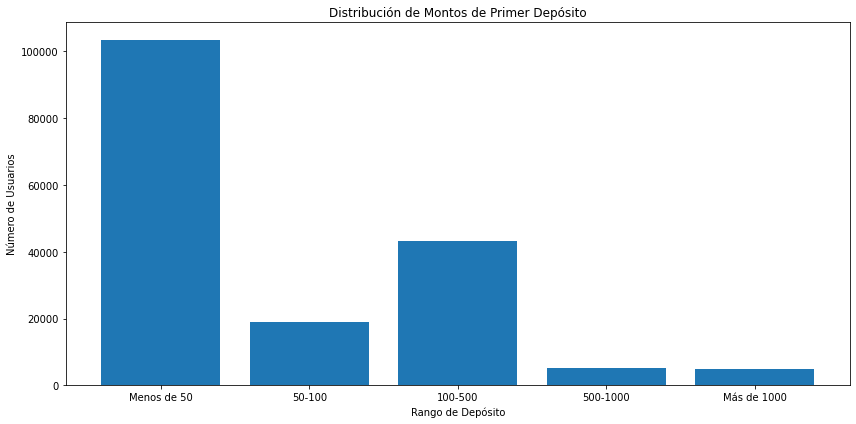

In [10]:
deposit_amount_analysis = spark.sql("""
    SELECT 
        CASE
            WHEN fiat_first_deposit_amount < 50 THEN 'Menos de 50'
            WHEN fiat_first_deposit_amount >= 50 AND fiat_first_deposit_amount < 100 THEN '50-100'
            WHEN fiat_first_deposit_amount >= 100 AND fiat_first_deposit_amount < 500 THEN '100-500'
            WHEN fiat_first_deposit_amount >= 500 AND fiat_first_deposit_amount < 1000 THEN '500-1000'
            ELSE 'Más de 1000'
        END as deposit_range,
        COUNT(*) as user_count,
        AVG(fiat_first_deposit_amount) as avg_amount
    FROM customers
    WHERE fiat_first_deposit_amount IS NOT NULL
    GROUP BY 
        CASE
            WHEN fiat_first_deposit_amount < 50 THEN 'Menos de 50'
            WHEN fiat_first_deposit_amount >= 50 AND fiat_first_deposit_amount < 100 THEN '50-100'
            WHEN fiat_first_deposit_amount >= 100 AND fiat_first_deposit_amount < 500 THEN '100-500'
            WHEN fiat_first_deposit_amount >= 500 AND fiat_first_deposit_amount < 1000 THEN '500-1000'
            ELSE 'Más de 1000'
        END
    ORDER BY 
        CASE 
            WHEN deposit_range = 'Menos de 50' THEN 1
            WHEN deposit_range = '50-100' THEN 2
            WHEN deposit_range = '100-500' THEN 3
            WHEN deposit_range = '500-1000' THEN 4
            ELSE 5
        END
""")

print("Análisis de montos de primer depósito:")
deposit_amount_analysis.show()

deposit_range_pd = deposit_amount_analysis.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(deposit_range_pd['deposit_range'], deposit_range_pd['user_count'])
plt.title('Distribución de Montos de Primer Depósito')
plt.xlabel('Rango de Depósito')
plt.ylabel('Número de Usuarios')
plt.tight_layout()
plt.show()

In [5]:
# Análisis manual del JSON (sin cargarlo en Spark para evitar problemas de memoria)
import json

json_path = "/Users/nicolasasparriayara/Desktop/balance_report_2025-02-28.json"

# Cargar solo las claves principales
with open(json_path, 'r') as file:
    balance_data = json.load(file)

# Ver las claves principales
print("Claves principales del reporte de balance:")
for key in balance_data.keys():
    print(f"- {key}")

# Mostrar algunos valores principales
print("\nValores principales:")
for key in balance_data.keys():
    if isinstance(balance_data[key], (int, float, str)):
        print(f"{key}: {balance_data[key]}")
    elif isinstance(balance_data[key], dict) and len(balance_data[key]) < 5:
        print(f"{key}: {balance_data[key]}")
    else:
        print(f"{key}: [Datos complejos]")

# Crear una visualización simple de los datos principales si hay valores numéricos
numeric_values = {}
for key in balance_data.keys():
    if isinstance(balance_data[key], (int, float)):
        numeric_values[key] = balance_data[key]

if numeric_values:
    plt.figure(figsize=(10, 6))
    plt.bar(numeric_values.keys(), numeric_values.values())
    plt.title('Métricas Principales de Balance')
    plt.ylabel('Valor')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Claves principales del reporte de balance:
- totalCryptoEquity
- totalEquity
- totalPortfolio
- totalActual
- totalSales
- userInMargin
- userTickers
- balancesArray

Valores principales:
totalCryptoEquity: 13288646.25
totalEquity: 144228907.32
totalPortfolio: 152584236.80
totalActual: 8354392.20
totalSales: 937.28
userInMargin: [Datos complejos]
userTickers: [Datos complejos]
balancesArray: [Datos complejos]


In [12]:
import time

print("Simulando correr la query en este entorno...")
start_time = time.time()

complex_query_result = spark.sql("""
    SELECT 
        c.country,
        YEAR(c.fiat_first_deposit_created_at) as year,
        MONTH(c.fiat_first_deposit_created_at) as month,
        COUNT(DISTINCT c.user_id) as unique_users,
        SUM(c.fiat_first_deposit_amount) as total_deposit,
        AVG(c.fiat_first_deposit_amount) as avg_deposit,
        COUNT(CASE WHEN c.is_investor = 'true' THEN 1 END) as investor_count,
        COUNT(CASE WHEN c.is_trader = 'true' THEN 1 END) as trader_count
    FROM customers c
    WHERE 
        c.fiat_first_deposit_created_at IS NOT NULL
        AND c.status = 'ONBOARD_COMPLETED'
    GROUP BY 
        c.country,
        YEAR(c.fiat_first_deposit_created_at),
        MONTH(c.fiat_first_deposit_created_at)
    ORDER BY 
        year DESC, 
        month DESC, 
        total_deposit DESC
""")

complex_query_result.count()
spark_time = time.time() - start_time

print(f"Tiempo de ejecución en Spark: {spark_time:.2f} segundos")

print("\nResultados:")
complex_query_result.show(10)

Simulando correr la query en este entorno...
Tiempo de ejecución en Spark: 0.63 segundos

Resultados:
+-------+----+-----+------------+------------------+------------------+--------------+------------+
|country|year|month|unique_users|     total_deposit|       avg_deposit|investor_count|trader_count|
+-------+----+-----+------------+------------------+------------------+--------------+------------+
|     PE|2025|    4|         360|261383.96999999997| 726.0665833333333|           360|         253|
|     CO|2025|    4|         979|155130.16000000003|  158.457773237998|           979|         644|
|     EC|2025|    4|         179|          26422.53|147.61189944134077|           179|         138|
|     AR|2025|    4|          77|25478.979999999996| 330.8958441558441|            77|          55|
|     BO|2025|    4|          94|          14964.93|159.20138297872342|            94|          60|
|     MX|2025|    4|         120|11971.800000000001| 99.76500000000001|           120|          86

In [1]:
# Demostración de integración con PostgreSQL (solo código de ejm)
print("""
# Código para integración con PostgreSQL RDS en producción:

# 1. Lectura desde PostgreSQL:
df_from_pg = spark.read \\
    .format("jdbc") \\
    .option("url", "your_db") \\
    .option("dbtable", "schema.table_name") \\
    .option("user", "root") \\
    .option("password", "your_password") \\
    .option("driver", "org.postgresql.Driver") \\
    .load()

# 2. Escritura a PostgreSQL:
complex_query_result.write \\
    .format("jdbc") \\
    .option("url", "your_db") \\
    .option("dbtable", "analytics.monthly_metrics") \\
    .option("user", "root") \\
    .option("password", "your_password") \\
    .option("driver", "org.postgresql.Driver") \\
    .mode("append") \\
    .save()
""")


# Código para integración con PostgreSQL RDS en producción:

# 1. Lectura desde PostgreSQL:
df_from_pg = spark.read \
    .format("jdbc") \
    .option("url", "your_db") \
    .option("dbtable", "schema.table_name") \
    .option("user", "root") \
    .option("password", "your_password") \
    .option("driver", "org.postgresql.Driver") \
    .load()

# 2. Escritura a PostgreSQL:
complex_query_result.write \
    .format("jdbc") \
    .option("url", "your_db") \
    .option("dbtable", "analytics.monthly_metrics") \
    .option("user", "root") \
    .option("password", "your_password") \
    .option("driver", "org.postgresql.Driver") \
    .mode("append") \
    .save()

